### Lab-3 : Self-Practice

#### In this week, your self-practice task will consist to analyze the impact of class imballance on the performance of the logistic regression model.

#### Class imbalance is very common in real life. For example, in a classification problem to predict whether a person has a certain very rare disease, the dataset will always contain more negative samples than positive ones. This situation can have a significant impact on the performance of the model. You will analyze this situation in the case of the Titanic dataset used in the lab.

### 1. Load the titanic dataset and <b>PLOT</b> the proportion of positive and negative samples (survived vs non survived)

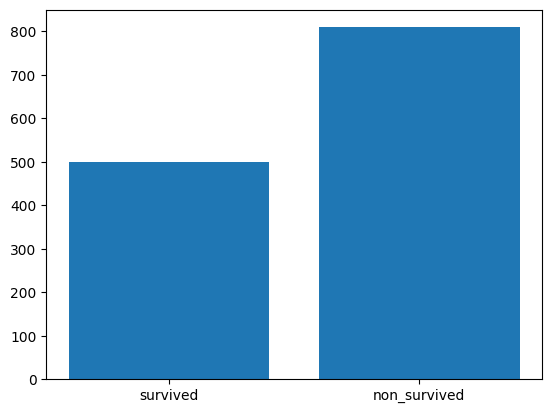

In [253]:
### write your code here. Load the dataset and plot (barplot) proportion of each class 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('titanic.csv')

plt.bar(['survived', 'non_survived'], [len(df[df.survived == 1]), len(df[df.survived == 0])])
plt.show()

#### Preprocess the data as it has been done in the lab, feel free to adapt

In [254]:
#### preprocess the data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Remove names for preprocessing
df.drop(['name'], axis=1, inplace=True)

# imputing missing values
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df)
df = pd.DataFrame(imputer.transform(df), columns=df.columns)

# one-hot-encode categorical features
def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    # create dataframe from encoded features with named columns
    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names_out(features_name))
    new_df = pd.concat([df, new_cols], axis=1)    
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

encoder = OneHotEncoder(sparse=False, drop='first')
f_names = ['sex', 'embarked']
encoder.fit(df[f_names])
df = ohe_new_features(df, f_names, encoder)

# feature scaling
scaler = MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), columns=df.columns)

## 2. Impact of class imballance. 
##### Now, you will `artificially` imbalance the dataset. From the original dataset, create different dataset with the following class representations (drop samples from one class): 
##### 1. 20% vs 80%
##### 2. 30% vs 70%
##### 3. 40% vs 60%

## Split each data into train and test set as in the lab; train logistic regression model for each setting and report (PLOT) the accuracy, precision, and recall of each model

In [255]:
def imbalance_dataset(data: pd.DataFrame, column: str, proportion: float) -> pd.DataFrame:
    # chosen column has to be binary distributed
    # https://www.wolframalpha.com/input?i=%28a+-+x%29+%2F+%28a+-+x+%2B+b+-+y%29+%3D+p%2C+%28b+-+y%29+%2F+%28a+-+x+%2B+b+-+y%29+%3D+1+-+p+find+x%2C+y

    p = proportion

    df = data.copy()
    classes = df[column].unique()

    df_one = df[df[column] == classes[0]] # records of the first type
    df_two = df[df[column] == classes[1]] # records of the second type

    # make dataframes of equal lengths,
    # then choose proportional number of records
    if len(df_one) > len(df_two):
        df_one = df_one.drop(df_one.index[range(0, len(df_one) - len(df_two))])
        df_one = df_one.iloc[:int(len(df_one) * (1 - p)), :]
        df_two = df_two.iloc[:int(len(df_two) * p), :]
    else:
        df_two = df_two.drop(df_two.index[range(0, len(df_two) - len(df_one))])
        df_two = df_two.iloc[:int(len(df_two) * (1 - p)), :]
        df_one = df_one.iloc[:int(len(df_one) * p), :]

    df = pd.concat([df_one, df_two])
    
    print("first = {}%, second = {}%"
        .format(
            len(df_one) / len(df) * 100, len(df_two) / len(df) * 100
        )
    )

    return df

In [256]:
### write your code here 
df_20_t_80 = imbalance_dataset(df, 'survived', 0.2)
df_30_t_70 = imbalance_dataset(df, 'survived', 0.3)
df_40_t_60 = imbalance_dataset(df, 'survived', 0.4)

first = 20.0%, second = 80.0%
first = 30.0%, second = 70.0%
first = 40.0%, second = 60.0%


In [264]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

dfs = [df_20_t_80, df_30_t_70, df_40_t_60]
y_preds = []
y_tests = []
for frame in dfs:
    x_train, x_test, y_train, y_test = train_test_split(frame.loc[:, 'pclass':], frame['survived'], 
        test_size=0.1, stratify=frame['survived'], random_state=0)
    logReg = LogisticRegression(random_state=0)
    logReg.fit(x_train, y_train)
    y_pred = logReg.predict(x_test)
    y_preds.append(y_pred)
    y_tests.append(y_test)

print(y_preds[0])
print(y_tests[0])

TypeError: 'numpy.ndarray' object is not callable

In [258]:
from sklearn import metrics

titles = ['20 to 80', '30 to 70', '40 to 60']

results = [[],[],[]]
for idx, y_pred in enumerate(y_preds):
    accuracy = metrics.accuracy_score(y_tests[idx], y_pred)
    precision = metrics.precision_score(y_tests[idx], y_pred)
    recall = metrics.recall_score(y_tests[idx], y_pred)
    results[0].append(accuracy)
    results[1].append(precision)
    results[2].append(recall)

In [259]:
def print_metrics(result, titles):
    plt.barh(titles, result[0])   
    for i in range(len(titles)):
        plt.text(1,i,result[0][i])
    
    plt.xlim([0,1])
    plt.title('Accuracy')
    plt.show()


    plt.barh(titles, result[1])   
    for i in range(len(titles)):
        plt.text(1,i,result[1][i])
    
    plt.xlim([0,1])
    plt.title('Precision')
    plt.show()


    plt.barh(titles, result[2])   
    for i in range(len(titles)):
        plt.text(1,i,result[2][i])
    
    plt.xlim([0,1])
    plt.title('Recall')
    plt.show()

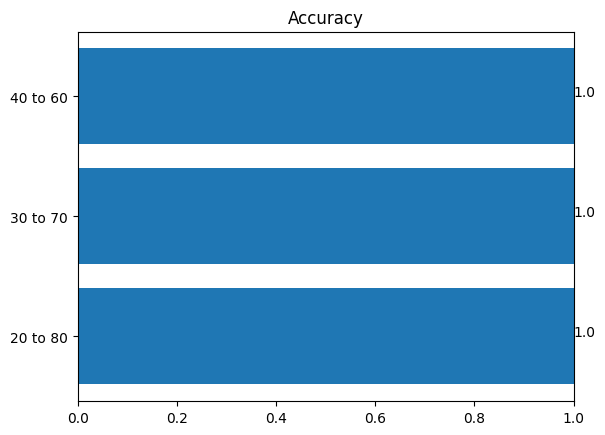

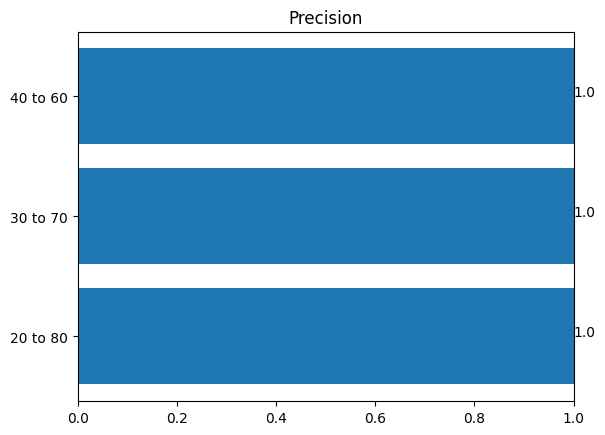

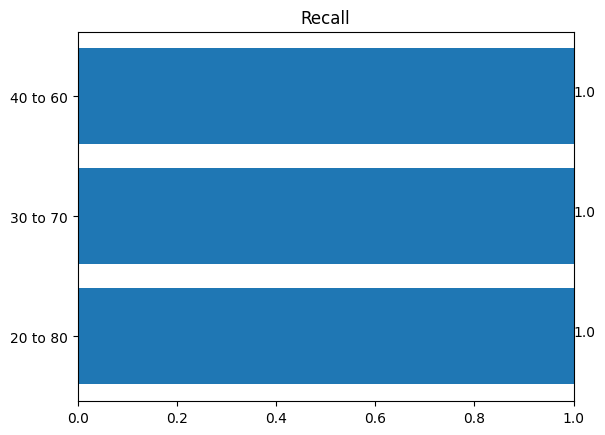

In [260]:
print_metrics(results, titles)

## 3. Analyse the class-wise accuracy. 
#### For each model, plot (bar plots) the class-wise accuracy, i.e., the accuracy for each class.

### BALANCE DATA SET IS BETTER

In [261]:
#### write your code 

## 4. Report 
### Write a small report (few sentences) to discuss from your analysis, the impact of class imballance on logistic model's performance 

`Write your report here`